In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from sklearn.cluster import KMeans  # k-means 군집분석
from sklearn.metrics import silhouette_score  # 군집분석 평가를 위한 silhouette 값 계산
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer
from collections import Counter
import datetime as dt
import math
from sklearn import metrics
#from sklearn import preprocessing #로그 변환을 위한 라이브러리 

/Users/seongyoon/programming/program/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)

In [3]:
#%pip install pandas-profiling
import pandas_profiling as pp

In [4]:
cs = pd.read_csv('L사_고객정보.csv')
gd = pd.read_csv('L사_상품정보.csv')
tr = pd.read_csv('L사_거래정보.csv')
lg = pd.read_csv('L사_로그정보.csv')

/Users/seongyoon/programming/program/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Data 분석 및 병합(Merge)

우선 고객정보 데이터, 상품 정보 데이터, 거래 정보 데이터를 병합.

In [5]:
gd.pd_c = gd.pd_c.astype(str).str.zfill(4)
df = pd.merge(tr, gd, on = 'pd_c', how = 'left')
df = df.merge(cs)
df['de_dt'] = df['de_dt'].astype(str).astype('datetime64') # 날짜정보를 담고 있는 de_dt 컬럼의 데이터 유형이 정수이기 때문

# 2. Data Cleansing
2.1 buy_am 이상치 제거 <br/>
2.2 buy_ct 가 0이라면 환불한 것으로 가정하여 해당 행 삭제<br/>
2.3 상품 분류에 따른 상품가격의 평균으로 buy_am의 결측값을 채우기

## 2.1 buy_am 이상치(Outlier) 제거 <br>
-IQR를 통해 이상치 행을 찾아 해당 행을 삭제한다.

In [6]:
#이상치 제거 함수
def rm_outlier(x):
    q1 = x['buy_am'].quantile(0.25)
    q3 = x['buy_am'].quantile(0.75)
    iqr = q3-q1
    low = q1-1.5*iqr
    high = q3+1.5*iqr
    df_out = x.loc[(x['buy_am'] > low) & (x['buy_am'] < high)]
    return df_out
df = rm_outlier(df) #이상치 제거

## 2.2 buy_ct = 0 이라면 환불한 것으로 가정하여 해당 행 삭제 <br/>
buy_ct가 0보다 크고, pd_c에 대한 데이터가 존재하는 데이터는 사용 --> 이를 통해 buy_am 결측치를 채울수 있기 때문.<br/>
buy_ct 정보가 존재하지만 pd_c의 정보가 없다면 해당 열도 삭제할 것. --> 상품에 대한 정보를 알수 없기 때문에 상품군의 평균으로 buy_am을 채울수 없음

In [7]:
# buy_ct가 0이면 해당 상품 구매를 취소한 것으로 간주하여 해당 열 삭제. 즉 거래가 없었음.
a = df.query('buy_ct == 0').index.tolist()
df = df.drop(a)

In [8]:
#buy_am이 0이고 pd_c가 unknown일 경우 buy_am에 대한 가격을 예측하여 넣을 수 없기 때문에 이에 대한 데이터도 삭제.
b = df.query('buy_am == 0 & pd_c == "unknown"').index.tolist()
df = df.drop(b)

## 2.3 상품 분류에 따른 상품가격의 평균으로 buy_am의 결측값을 채우기 <br/>
pd_c 가 unknown 이라면 pass <br/>
pd_c의 정보가 존재하고, 이에 대한 상품 정보가 존재한다면 상품군의 평균 가격으로 buy_am을 대체.

2.3.1 구매한 상품의 단가 칼럼 추가
2.3.2 상품군(clac_nm2)에 따른 상품가격의 평균
2.3.3 상품군에 따른 가격 평균을 결측치에 삽입

## 2.3.1 구매한 상품의 단가 칼럼 추가

In [9]:
df['상품가격'] = df['buy_am'] /df['buy_ct']

In [10]:
#상품가격이 0인 데이터는 모두 해당 상품에 대한 가격에 대한 정보가 없음. 따라서 해당 행을 삭제
c = df.query('상품가격 == 0').index.tolist()
df = df.drop(c)

## 2.3.2 상품군(clac_nm2)에 따른 상품가격의 평균

In [11]:
#pd_c의 정보가 존재하고, 이에 대한 상품 정보가 존재한 데이터에 한하여 clac_nm2에 따른 평균 값을 추출.
a = df.query('pd_c != "unknown" & clac_nm2 !="NaN"')
prc_mean = a.groupby('clac_nm2')['상품가격'].mean().round()
prc_mean = prc_mean.reset_index().rename(columns={"index": "clac_nm2"})
prc_mean

,clac_nm2,상품가격
0,Adults' Bedding,7508.0
1,Air Freshners / Dehumidifiers / Odor Eliminators,6440.0
2,Alcoholic Beverage Sets,9580.0
3,Animal Clinics,1000.0
4,Arts / Crafts Supplies,3408.0
...,...,...
304,Women's Upper Bodywear / Tops,6553.0
305,Women's Wallets,10000.0
306,Writing Pads,4623.0
307,Writing Supplies,2702.0


## 2.3.3 상품군에 따른 가격 평균을 결측치에 삽입.

In [12]:
#df와 prc_mean을 merge
df = df.merge(prc_mean, on = 'clac_nm2')

In [13]:
def fun(x):
    if x > 0:
        return x #buy_am의 정보가 있다면 이에 대한 행은 건들지 않음.
    else:
        df['상품가격_y'] / df['buy_ct'] #상품 구매 개수가 1이 아닐 수도 있기 때문에 구매 수로 나눔

df['상품단가'] = df['상품가격_x'].apply(fun)

In [14]:
df = df.drop(['상품가격_x', '상품가격_y'], axis= 1)

In [15]:
def sel(x):
    if x > 0:
        return x
    else:
        df['상품단가'] * df['buy_ct']
        
## 조건을 줘야함. buy_am이 0인 것들에 한하여 아래 코드를 실행해야함.
df['buy_am'] = df['buy_am'].apply(sel)       

In [16]:
df['구매요일'] = df.groupby('clnt_id')['de_dt'].apply(lambda x: x.dt.day_name())
df['clnt_age'] = df['clnt_age'].astype(int)
df['clnt_gender'] = df['clnt_gender'].apply(lambda x: '남' if x == 'M' else '여')

# 데이터 요약

In [17]:
# 데이터 요약
print('=======  분석 데이터 요약  =======')
print('▶ 고객수:', df.clnt_id.nunique())
print(f'▶ 상품수: 대분류({df.clac_nm1.nunique()}), 중분류({df.clac_nm2.nunique()}), 소분류({df.clac_nm3.nunique()})')
print('▶ 업종수:', df.biz_unit.nunique())
print(f'▶ 기간: {df.de_dt.min()} ~ {df.de_dt.max()} ({(df.de_dt.max()-df.de_dt.min()).days+1}일)')

=======  분석 데이터 요약  =======
▶ 고객수: 9290
▶ 상품수: 대분류(57), 중분류(309), 소분류(1401)
▶ 업종수: 6
▶ 기간: 2019-07-01 00:00:00 ~ 2019-09-30 00:00:00 (92일)


In [18]:
df.to_csv('cs_tr.csv', index=False)

# 3. 고객 분석 변수 설정 및 데이터 변경

## 3.1. 고객 -clnt_gender

In [19]:
#clnt_id에 따른 clnt_gender를 한글로 '남', '여'로 변경. 

ft = pd.DataFrame({'clnt_id': df.clnt_id.unique()})
ft = ft.merge(cs, how = 'left')
ft['clnt_gender'] = ft['clnt_gender'].apply(lambda x: '남' if x == 'M' else '여')
ft.rename(columns={'clnt_gender': '성별', 'clnt_age': '연령대'}, inplace=True)
ft['연령대'] = ft['연령대'].astype(int)

## 3.2. 고객 -구매금액(buy_am)

In [20]:
#clnt_id에 따른 buy_am의 평균과 그 횟수를 저장.

buy = df.groupby('clnt_id')['buy_am'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size)
]).reset_index()
ft = ft.merge(buy, how='left')

## 3.3. 고객-상품단가

In [21]:
#clnt_id에 따른 구한 '상품단가'의 평균을 저장.

unit_prc = df.groupby('clnt_id')['상품단가'].agg([
    ('구매상품평균단가', lambda x: np.round(np.mean(x),2))
]).reset_index()
ft = ft.merge(unit_prc, how='left')

## 3.4. 고객 - 구매일자(de_dt)

In [22]:
#clnt_id에 따른 'de_dt(구매일자)'의 횟수, 구매주기, 그리고 휴먼기간을 저장.

a = np.datetime64(max(df['de_dt']))
#전체 데이터의 끝인 시점을 메모리에 적재한 후에 연산
date = df.groupby('clnt_id')['de_dt'].agg([
    ('내점일수',lambda x: x.nunique()),
    ('구매주기', lambda x: int(((x.max() - x.min()).days) / x.nunique())),
    ('휴먼기간', lambda x: a - x.max())
]).reset_index()
ft = ft.merge(date, how='left')
ft['휴먼기간'] = ft['휴먼기간'].dt.days.astype(int)

## 3.5. 고객 - 구매요일

In [23]:
#clnt_id에 따른 가장 많이 방문한 요일(최빈구매요일), 그리고 전체 방문횟수중 그 요일에 얼마나 집중적으로 방문했는지(최빈구매요일집중도)를 저장.

max_day = df.groupby('clnt_id')['구매요일'].agg([
    ('최빈구매요일',lambda x: x.mode()[0][:3]), #mode 함수를 사용해서 groupby한 것중의 최빈값을 구한다.
    ('최빈구매요일집중도', lambda x: round( x.value_counts()[0] / x.size,2))
]).reset_index()
ft = ft.merge(max_day, how='left')

## 3.6. 고객 - 구매시각(de_tm)

In [24]:
#clnt_id에 따른 'de_tm(구매시각)'의 시간 부분만을 추출

time = df.groupby('clnt_id')['de_tm'].agg([
    ('주구매시간', lambda x: int(x.str[:2].value_counts().index[0]))
]).reset_index()
ft = ft.merge(time, how='left')

# 평균 구매시간 deltatime64 --> sec로 바꿔서 mean로 평균값 처리.

## 3.7. 고객 - 상품대분류명(clac_num1)

In [25]:
#clnt_id에 따른 구매한 상품중 가장 많이 구매한 'clac_nm1(상품대분류명)'과 이에 대한 재구매율을 저장.

clac = df.groupby('clnt_id')['clac_nm1'].agg([
    ('최빈구매상품군',lambda x: x.mode()[0]),    
    ('상품군재구매율',lambda x: round(x.value_counts()[0] / x.size,2)) #mode 함수를 사용해서 groupby한 것중의 최빈값을 구한다.
]).reset_index()

ft = ft.merge(clac, how='left')

## 3.8. 고객 - 장바구니추가(action type = 3)

In [26]:
#action_type의 3 은 '장바구니추가' 건수가 많을 수록 구매 건수가 많을까??

In [27]:
#로그 정보 중에 action_type의 값이 3인 것은 '장바구니추가'행위를 한 것을 나타낸다.
#clnt_id에 따른 '장바구니추가(action_type == 3)'의 횟수를 저장한다.

sh_bk = lg.query('action_type == "3"').groupby('clnt_id')['action_type'].agg([
    ('장바구니추가건수', np.size )
]).reset_index()
sh_bk.fillna(0)
ft = ft.merge(sh_bk, how='left')
ft['장바구니추가건수'] = ft['장바구니추가건수'].fillna(0)

## 3.9. 고객 - 총페이지조회건수(tot_sess_hr_v) & 조회경과 시간(hit_pss_tm)

In [28]:
#clnt_id에 따른 '총페이지조회건수(tot_sess_hr_v)'의 평균을 '조회경과 시간(hit_pss_tm)'으로 나누어
#'조회시간당 페이지조회건수'를 저장한다. 
# 조회경과 시간(hit_pss_tm)의 단위는 밀리세컨드 --> x1000을 하여 초당 조회페이지건수를 계산함.
# 해당 값이 적으면 작을 수록 한페이지에 오래 머문다는 의미

a = lg.groupby('clnt_id')['tot_sess_hr_v'].mean().reset_index()
b = lg.groupby('clnt_id')['hit_pss_tm'].mean().reset_index()

a['tot_sess_hr_v'] = a['tot_sess_hr_v'].apply(lambda x: 0 if x == 0 else x)
a['tot_sess_hr_v'] = a['tot_sess_hr_v'].fillna(0)
b['hit_pss_tm'] = b['hit_pss_tm'].apply(lambda x: 1 if x == 0 else x)
b['hit_pss_tm'] = b['hit_pss_tm'].fillna(1)

s_tm = pd.merge(a,b)
s_tm
ft['세션_페이지'] = round(s_tm['tot_sess_hr_v'] / s_tm['hit_pss_tm'] *1000, 2)

## 3.10. 고객- 유입채널(trfc_src)

In [29]:
#clnt_id에 따른 최다 접속 'trfc_src(유입채널)'을 저장.

ch = lg.groupby('clnt_id')['trfc_src'].agg([
    ('최다유입채널', lambda x: x.mode() )
]).reset_index()
ft = ft.merge(ch, how='left')

## 3.11. 고객- 접속기기유형(dvc_ctg_nm)


In [30]:
#clnt_id에 따른 최다 접속 'dvc_ctg_nm(기기유형)'을 저장.

dev = lg.groupby('clnt_id')['dvc_ctg_nm'].apply(lambda x: x.mode()).reset_index()
ft = ft.merge(dev, on = 'clnt_id', how='left')
ft = ft.rename(columns={"dvc_ctg_nm": "최다접속기기유형"})
ft = ft.drop('level_1', axis = 1)

## 3.10. 정렬

In [31]:
#clnt_id와 성별을 제외한 이산형 변수를 오른쪽으로 정렬.

ft = ft[['clnt_id','성별','연령대', '총구매액', '구매건수','구매상품평균단가',
         '내점일수', '구매주기', '휴먼기간', '최빈구매요일집중도', '주구매시간',
         '상품군재구매율','장바구니추가건수','세션_페이지',
         '최빈구매요일','최빈구매상품군','최다유입채널', '최다접속기기유형']]
ft

ft.to_excel('feature_1.xlsx', index=False) #고객 정보 데이터를 저장.

# 4. Plot를 통한 데이터 시각화 및 분석

In [32]:
ft = pd.read_excel('feature.xlsx')
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)

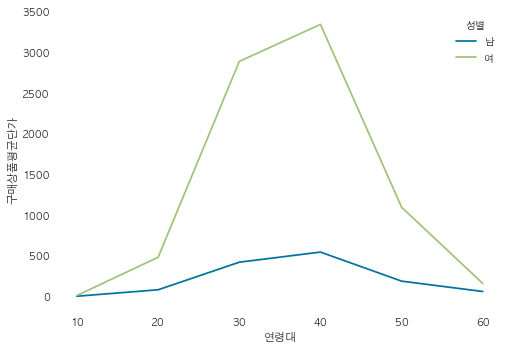

In [33]:
a = pd.pivot_table(ft,values = '구매상품평균단가', index = '연령대', columns = '성별',
              aggfunc= np.size)
a.plot()
plt.ylabel("구매상품평균단가")
plt.show()

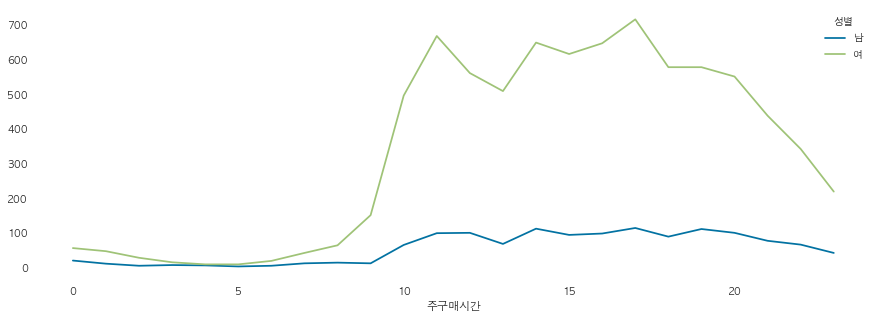

In [34]:
#남여간의 주구매시간 그래프
pd.pivot_table(ft, values = 'clnt_id', index = '주구매시간', columns = '성별',
              aggfunc = 'count').plot(figsize = (15,5))
plt.show()

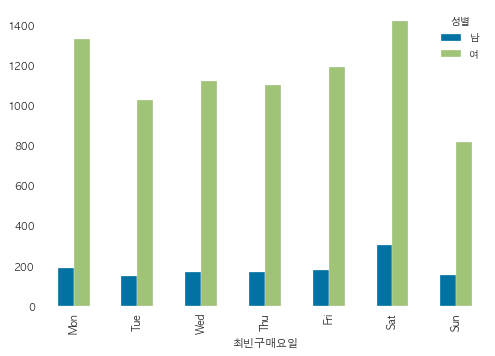

In [35]:
day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

a = pd.pivot_table(ft, values = 'clnt_id', index = '최빈구매요일', columns = '성별',
              aggfunc = 'count')
a = a.reindex(index = day)
a.plot.bar()
plt.show()

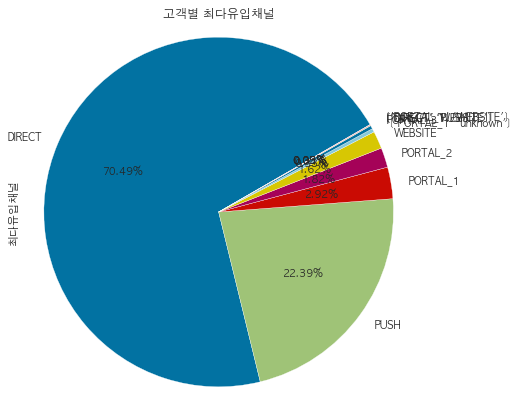

In [36]:
a = ft.query('최다유입채널 != "unknown"')['최다유입채널']
plt.figure(figsize=(15,15))
a.value_counts().plot.pie(autopct='%.2f%%', figsize=(7,7), 
                                      startangle=30, legend=False)
plt.title("고객별 최다유입채널")
plt.axis('equal')
plt.show()

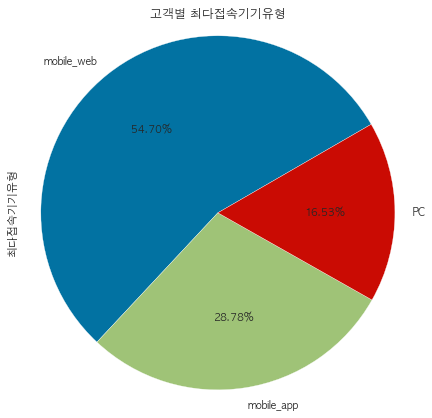

In [37]:
a = ft[ft['최다접속기기유형'].notnull()]
plt.figure(figsize=(8,8))
a['최다접속기기유형'].value_counts().plot.pie(autopct='%.2f%%', figsize=(7,7), 
                                      startangle=30, legend=False)
plt.title("고객별 최다접속기기유형")
plt.axis('equal')
plt.show()

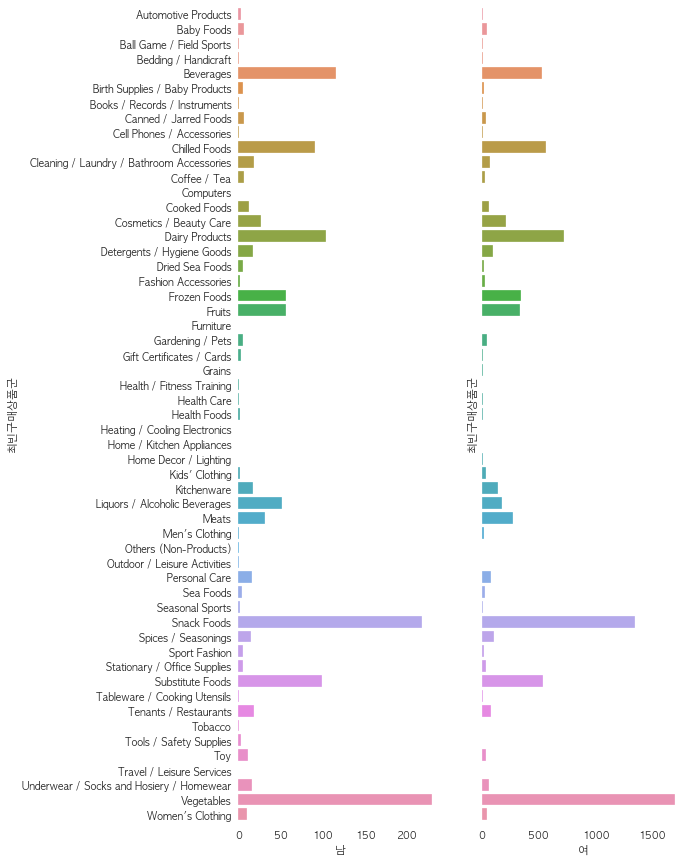

In [38]:
a = pd.pivot_table(ft,values = 'clnt_id', index = '최빈구매상품군', columns = '성별',
              aggfunc= np.size)
f, axes = plt.subplots(1, 2, figsize=(8, 15), sharey=True)
sns.barplot(data=a.reset_index(), y='최빈구매상품군', x='남', ax=axes[0])
sns.barplot(data=a.reset_index(), y='최빈구매상품군', x='여', ax=axes[1])
plt.show()